In [174]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mrmr import mrmr_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform
from sklearn.model_selection import train_test_split
from scipy.stats import randint, uniform
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import catboost as cb
from sklearn.model_selection import cross_val_score

# Pre-processing

## Load data

In [175]:
negative_serology = ["SRR22402286","SRR22402358","SRR22402336","SRR22402315","SRR22402330","SRR22402374","SRR22402370","SRR22402355","SRR22402353","SRR22402352","SRR22402351","SRR22402350","SRR22402349","SRR22402384","SRR22402297","SRR22402275","SRR22402318","SRR22402347","SRR22402383","SRR22402317","SRR22402304","SRR22402371","SRR22402264","SRR22402365","SRR22402369","SRR22402368","SRR22402367","SRR22402366","SRR22402364","SRR22402292","SRR22402299","SRR22402291","SRR22402305","SRR22402277","SRR22402270","SRR22402265","SRR22402259","SRR22402258","SRR22402327","SRR22402319","SRR22402310","SRR22402306","SRR22402303","SRR22402328","SRR22402332","SRR22402331","SRR22402266","SRR22402307","SRR22402333","SRR22402329"]
X = pd.read_csv("../features_species.csv", sep=";")
# filter out samples with negative TG serology
X = X.loc[~X["Sample"].isin(negative_serology)]
y = pd.read_csv("../../labels.csv", sep=";")
y = y.loc[y["Sample"].isin(X["Sample"])].set_index("Sample", drop=True)["Label"]
X = X.set_index("Sample", drop=True)
X.shape

(122, 8889)

[Text(0, 0, 'Healthy'), Text(1, 0, 'CD')]

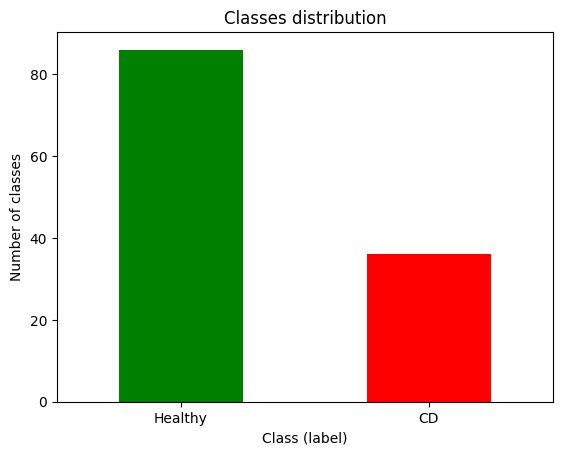

In [176]:
ax = y.value_counts().plot(
  kind='bar',
  color=["green","red"],
  title="Classes distribution",
  ylabel="Number of classes",
  xlabel="Class (label)",
  rot=0
)
ax.set_xticklabels(["Healthy", "CD"])

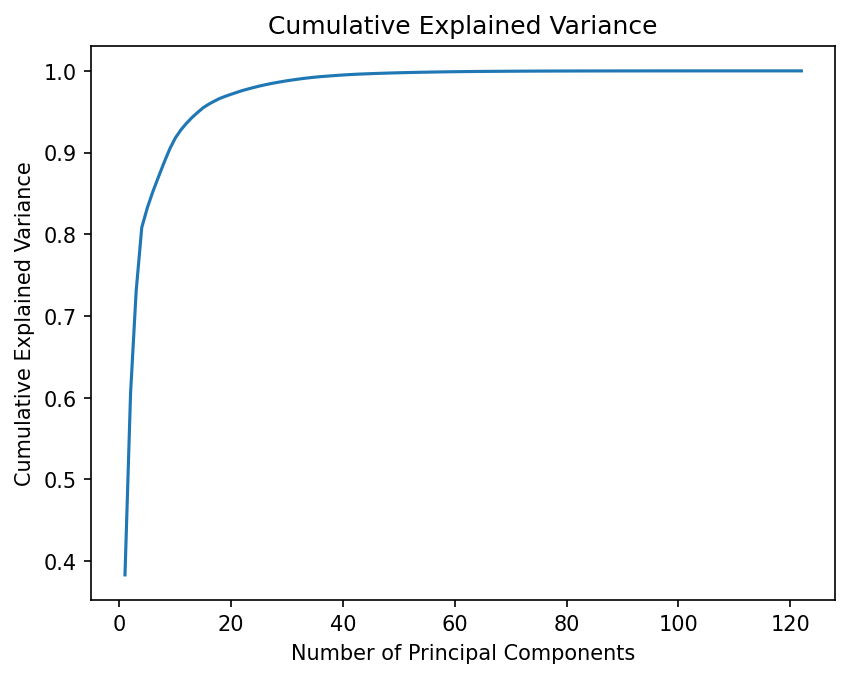

In [177]:
# Perform PCA
pca = PCA(random_state=42)
pca.fit(X)
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)
fig = plt.figure(dpi=150)
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance)
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

## Remove features with less than n% unique values

In [178]:
# Calculate the percentage of unique values for each feature
unique_percentages = (X.nunique() / X.shape[0]) * 100

# Identify features with more than 90% same values
features_to_drop = unique_percentages[unique_percentages < 50].index

# Remove the identified features from the DataFrame
filtered_X = X.drop(features_to_drop, axis=1)
filtered_X.shape

(122, 5265)

## MRMR to select k features 

In [179]:
selected_features = mrmr_classif(X=filtered_X, y=y, K=30)
X[selected_features]

100%|██████████| 30/30 [00:11<00:00,  2.54it/s]


,Paracoccus aminophilus,Bifidobacterium choerinum,Acinetobacter haemolyticus,Candidatus Nanosynbacter sp. HMT-352,Acidaminococcus intestini,Arthrobacter sp. NtRootA1,Enterococcus faecalis,Sphingomonas sp. SUN039,Haemophilus parahaemolyticus,Sneathiella aquimaris,...,Blautia hansenii,Brevundimonas sp. MF30-B,Streptococcus australis,Sulfitobacter sp. THAF37,Faecalibacterium sp. HTF-F,Methylobacterium sp. WL1,Veillonella atypica,Brevibacterium linens,Rothia sp. ZJ932,Enterococcus durans
Sample,,,,,,,,,,,,,,,,,,,,,
SRR15595350,19.0,73,13,53.0,156,8.0,94,5.0,8.0,7.0,...,3215,24.0,8,10.0,13724,13.0,45,36,13.0,17
SRR15595341,8.0,74,2,58.0,98,19.0,633,1.0,4.0,8.0,...,2578,8.0,24,4.0,9008,16.0,38,11,12.0,13
SRR15595330,7.0,24,2,187.0,79,2.0,61,21.0,3.0,1.0,...,2968,1.0,29,6.0,36712,5.0,59,32,14.0,9
SRR15595319,6.0,233,2,58.0,81,18.0,52,7.0,16.0,34.0,...,2363,45.0,68,4.0,22385,9.0,83,15,8.0,15
SRR15595315,9.0,109,8,27.0,198,18.0,30,14.0,4.0,17.0,...,1673,34.0,362,13.0,7949,22.0,1067,12,3.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR22402382,90.0,220,62,53.0,731,50.0,339,126.0,48.0,68.0,...,7683,76.0,59,39.0,8098,64.0,76,122,46.0,62
SRR22402381,115.0,116,5,52.0,311,10.0,283,97.0,5.0,23.0,...,2576,32.0,63,15.0,27379,38.0,59,304,23.0,22
SRR22402268,24.0,104,88,338.0,812,20.0,33584,22.0,48.0,18.0,...,8665,25.0,2323,26.0,43509,9.0,16006,28,9.0,639


In [180]:
corr_df = X[selected_features].join(y)
corr_m = corr_df.corr()["Label"]
corr_m[abs(corr_m) > 0.2]

Paracoccus aminophilus                 -0.438950
Candidatus Nanosynbacter sp. HMT-352    0.244431
Acidaminococcus intestini               0.247527
Arthrobacter sp. NtRootA1              -0.380996
Sphingomonas sp. SUN039                -0.371869
Sneathiella aquimaris                  -0.394370
Paenibacillus graminis                 -0.378100
Actinomyces sp. oral taxon 414          0.320364
Streptomyces sp. MMBL 11-1             -0.373339
Streptococcus sp. A12                   0.230229
Bradyrhizobium sp. 14AB                -0.383676
Stieleria neptunia                     -0.394556
Nitratireductor sp. SY7                -0.387324
Sulfitobacter sp. JL08                 -0.375750
Haemophilus parainfluenzae              0.257614
Pseudorhodoplanes sinuspersici         -0.392108
Brevundimonas sp. MF30-B               -0.363838
Streptococcus australis                 0.237974
Sulfitobacter sp. THAF37               -0.368939
Faecalibacterium sp. HTF-F             -0.317722
Methylobacterium sp.

## Split the data

In [181]:
# Create an instance of the SMOTE algorithm
smote = SMOTE(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.3, random_state=42, stratify=y)
# Apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_test_resampled, y_test_resampled = smote.fit_resample(X_test, y_test)
y_train_resampled.value_counts(), y_test_resampled.value_counts()

(Label
 1    60
 0    60
 Name: count, dtype: int64,
 Label
 1    26
 0    26
 Name: count, dtype: int64)

# Models

## Logistic regression

Classification report:               precision    recall  f1-score   support

           0       0.83      0.92      0.87        26
           1       0.75      0.55      0.63        11

    accuracy                           0.81        37
   macro avg       0.79      0.73      0.75        37
weighted avg       0.80      0.81      0.80        37

Area under the curve 0.7342657342657343


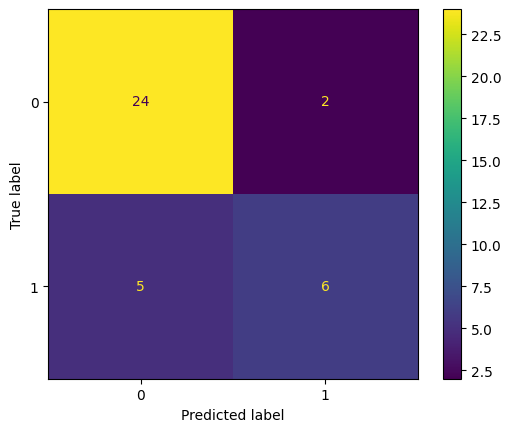

{'logreg__C': 0.9}

In [182]:
pipeline = Pipeline([
    ('log_transform', FunctionTransformer(np.log1p)),
    ('min_max_scale', MinMaxScaler()),
    ('logreg', LogisticRegression(random_state=42))
])
# define the hyperparameters to search over
param_grid = {
    'logreg__C': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
}

# perform grid search to find the best hyperparameters
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1)
# Fit the GridSearchCV object on the training data
grid_search.fit(X_train_resampled, y_train_resampled)
# Get the best estimator and make predictions on the testing data
best_estimator = grid_search.best_estimator_
y_pred = best_estimator.predict(X_test)

# Compute accuracy for the best found RF
report = classification_report(y_test, y_pred)
params = grid_search.best_params_
# print("Accuracy:", accuracy)
print(report)
print("Area under the curve", roc_auc_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=best_estimator.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=best_estimator.classes_)
disp.plot()
plt.show()
grid_search.best_params_

In [183]:
best_estimator = grid_search.best_estimator_
y_pred = best_estimator.predict(X_test)

# Compute accuracy for the best found RF
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).T
report_df.to_csv("baseline_classification_report.csv", sep=";")

## Random forest

Accuracy: 0.8108108108108109
Best score: 0.875
              precision    recall  f1-score   support

           0       0.85      0.88      0.87        26
           1       0.70      0.64      0.67        11

    accuracy                           0.81        37
   macro avg       0.78      0.76      0.77        37
weighted avg       0.81      0.81      0.81        37

Area under the curve 0.7604895104895104


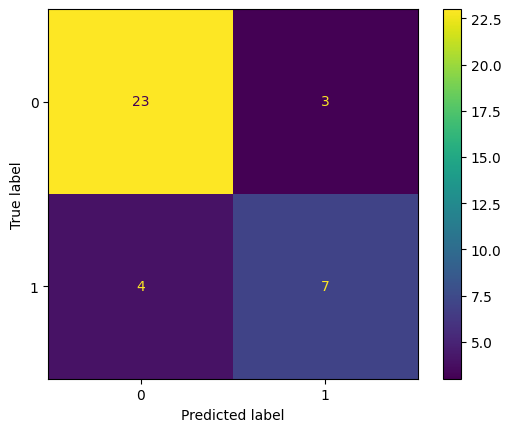

{'rf__criterion': 'entropy',
 'rf__max_depth': 5,
 'rf__max_features': 'log2',
 'rf__n_estimators': 4}

In [184]:
# Define the Pipeline
rf_pipeline = Pipeline([
    ('log_transform', FunctionTransformer(np.log1p)),  # Step 1: log transformation
    ('rf', RandomForestClassifier(random_state=42, warm_start=True))  # Step 4: Random Forest
])
rf_param_grid = {
    # 'variance_filter__threshold': [0.1], # grid search value for variance filter threshold
    'rf__n_estimators': [1,2,3,4,5],  # Step 4: grid search for n_estimators
    'rf__max_depth': [1,2,3,4,5,6,7,8,9,10, None],  # Step 4: grid search for max_depth
    'rf__criterion' :['gini', 'entropy', 'log_loss'], # Step 4: grid search for criterion
    'rf__max_features': ['sqrt', 'log2'], # Step 4: grid search for number of max_features
}

# Define the GridSearchCV object
rf_grid_search = GridSearchCV(rf_pipeline, param_grid=rf_param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV object on the training data
rf_grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best estimator and make predictions on the testing data
best_estimator = rf_grid_search.best_estimator_
y_pred = best_estimator.predict(X_test)

# Compute accuracy for the best found RF
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Best score:", rf_grid_search.best_score_)
# Compute accuracy for the best found RF
report = classification_report(y_test, y_pred)
# pd.DataFrame(report).T.to_csv("best_model_rf_classification_report.csv", sep=";")
params = rf_grid_search.best_params_
# print("Accuracy:", accuracy)
print(report)
print("Area under the curve", roc_auc_score(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred, labels=best_estimator.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=best_estimator.classes_)
disp.plot()
plt.show()
rf_grid_search.best_params_

In [185]:
f_imp = rf_grid_search.best_estimator_['rf'].feature_importances_
# print(f_imp)
rf_grid_search.best_estimator_.feature_names_in_[f_imp > 0.1]

array(['Arthrobacter sp. NtRootA1', 'Haemophilus parainfluenzae',
       'Faecalibacterium sp. HTF-F', 'Rothia sp. ZJ932'], dtype=object)

In [186]:
best_estimator = rf_grid_search.best_estimator_
scores = cross_val_score(best_estimator, X[selected_features], y, cv=5)
scores.std()

0.08390205930461753